## Anexa 3. Cod sursa - Aplicatia 3 - Grinda perete
## Studiu parametric al topologiei retelei
#### Importare module

In [1]:
import os
import itertools
import time
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
import keras
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import Sequential ,load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.metrics import r2_score, make_scorer
from IPython.display import HTML, Image

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

seed = 314159
np.random.seed(seed)

Using TensorFlow backend.


#### Incarcare set de date si previzualizare

In [2]:
filename = "deepbeams.csv"
database = pd.read_csv(filename)
print('Previzualizare set de date:')
display(database.head())
print('Dimensiuni set de date =',database.shape)

Previzualizare set de date:


,b,h,d,fc,fy,fyv,rpl,rl,rv,rh,s,apd,vtest
0,36.0,48.0,40.0,4100,67,61,0.0043,0.0293,0.0031,0.0030,11.0,1.85,1128.3
1,36.0,48.0,40.0,4100,67,61,0.0043,0.0293,0.0086,0.0030,4.0,1.85,1426.0
2,36.0,48.0,40.0,2800,65,63,0.0043,0.0293,0.0022,0.0022,10.0,1.85,1102.0
3,36.0,48.0,40.0,3000,65,63,0.0043,0.0293,0.0031,0.0030,11.0,1.85,930.0
4,36.0,48.0,40.0,4900,68,62,0.0022,0.0293,0.0031,0.0027,11.0,1.85,1096.0


Dimensiuni set de date = (179, 13)


#### Legenda
(1) b - latime grinda (in) <br>
(2) h - inaltime grinda (in)<br>
(3)	d	- inaltime utila (in)<br>
(4)	fc	- rezistenta la compresiune a betonului(psi)<br>
(5)	fy	- rezistenta la intindere a armaturilor longitudinale(ksi)<br>
(6)	fyv	- rezistenta la intindere a armaturilor transversale(ksi)<br>
(7)	rpl	- procentul armaturii longitudinale intinse<br>
(8)	rl	- procentul armaturii longitudinale comprimate<br>
(9) rv -  procentul armaturii transversale verticale<br>
(10) rh - procentul armaturii transversale orizontale<br>
(11) s -  pasul etrierilor (in)<br>
(12) apd - a/d raportul dintre distanta de aplicare a fortei taietoare și inaltimea utila a grinzii <br>
(13) vtest - forta taietoare maxima (include greutatea proprie)(kips)

#### Previzualizare grafica set de date de intrare

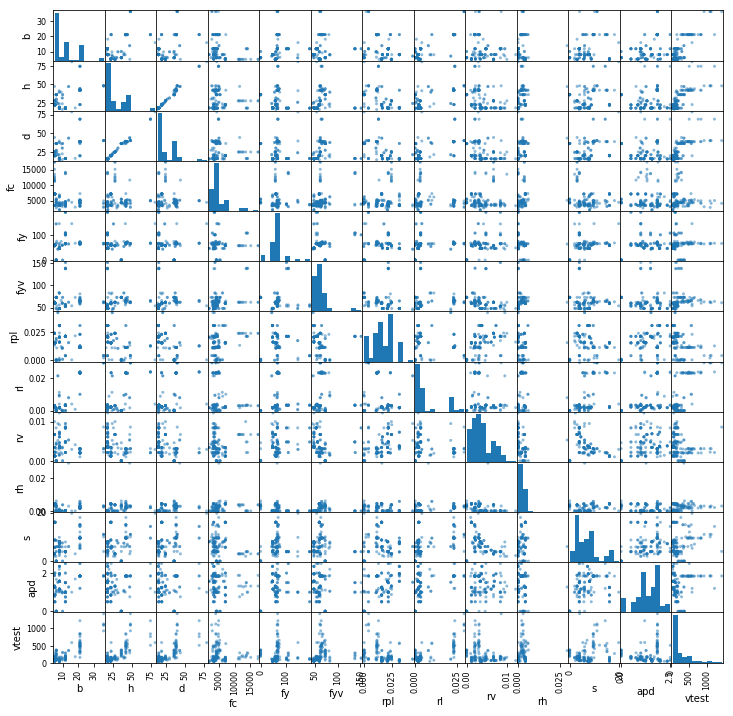

In [3]:
pd.plotting.scatter_matrix(database,figsize=(12, 12));

#### Matricea de corelatie

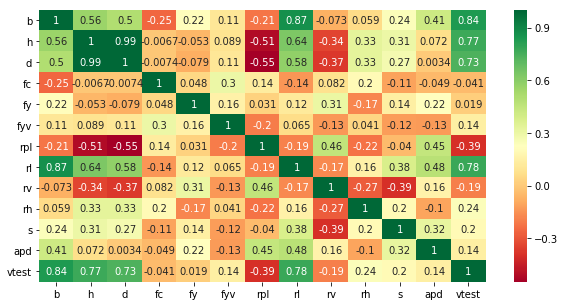

In [4]:
plt.subplots(figsize=(10, 5))
sns.heatmap(database.corr(), annot=True, cmap="RdYlGn");

### Date de antrenare si testare
Datele de testare si antrenare au fost alese aleator. Datele de testare reprezintă 25% din setul total de date. Valorile parametrilor de intrare au fost standardizate.

In [5]:
dataset = database.values
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:, 0:12], dataset[:, 12],
                                                        test_size=0.25, random_state=seed)
Xd = dataset[:, 0:12]
Yd = dataset[:, 12]
scaler_x = StandardScaler()
Xd_scalled = scaler_x.fit_transform(Xd)
X_train_scalled = scaler_x.transform(X_train)
X_test_scalled = scaler_x.transform(X_test)

In [6]:
def create_model(neurons=[3], hidden_layers=0):
    model = Sequential()
    neurons_1 = neurons[0]
    model.add(Dense(neurons_1, input_dim=12, activation='relu', 
                    kernel_initializer='normal', kernel_regularizer = 'l2'))
    for i in range(hidden_layers - 1):
        neurons_i = neurons[i + 1]
        # lname = 'hidden_' + str(i + 2)
        model.add(Dense(neurons_i, activation='relu', kernel_initializer='normal', kernel_regularizer = 'l2'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    global embedding_layer_names
    embedding_layer_names = set(layer.name for layer in model.layers)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
    return model

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Model initial
#### Antrenare

Timp de antrenare 414.1 secunde / 6.9 minute / 0.1 ore


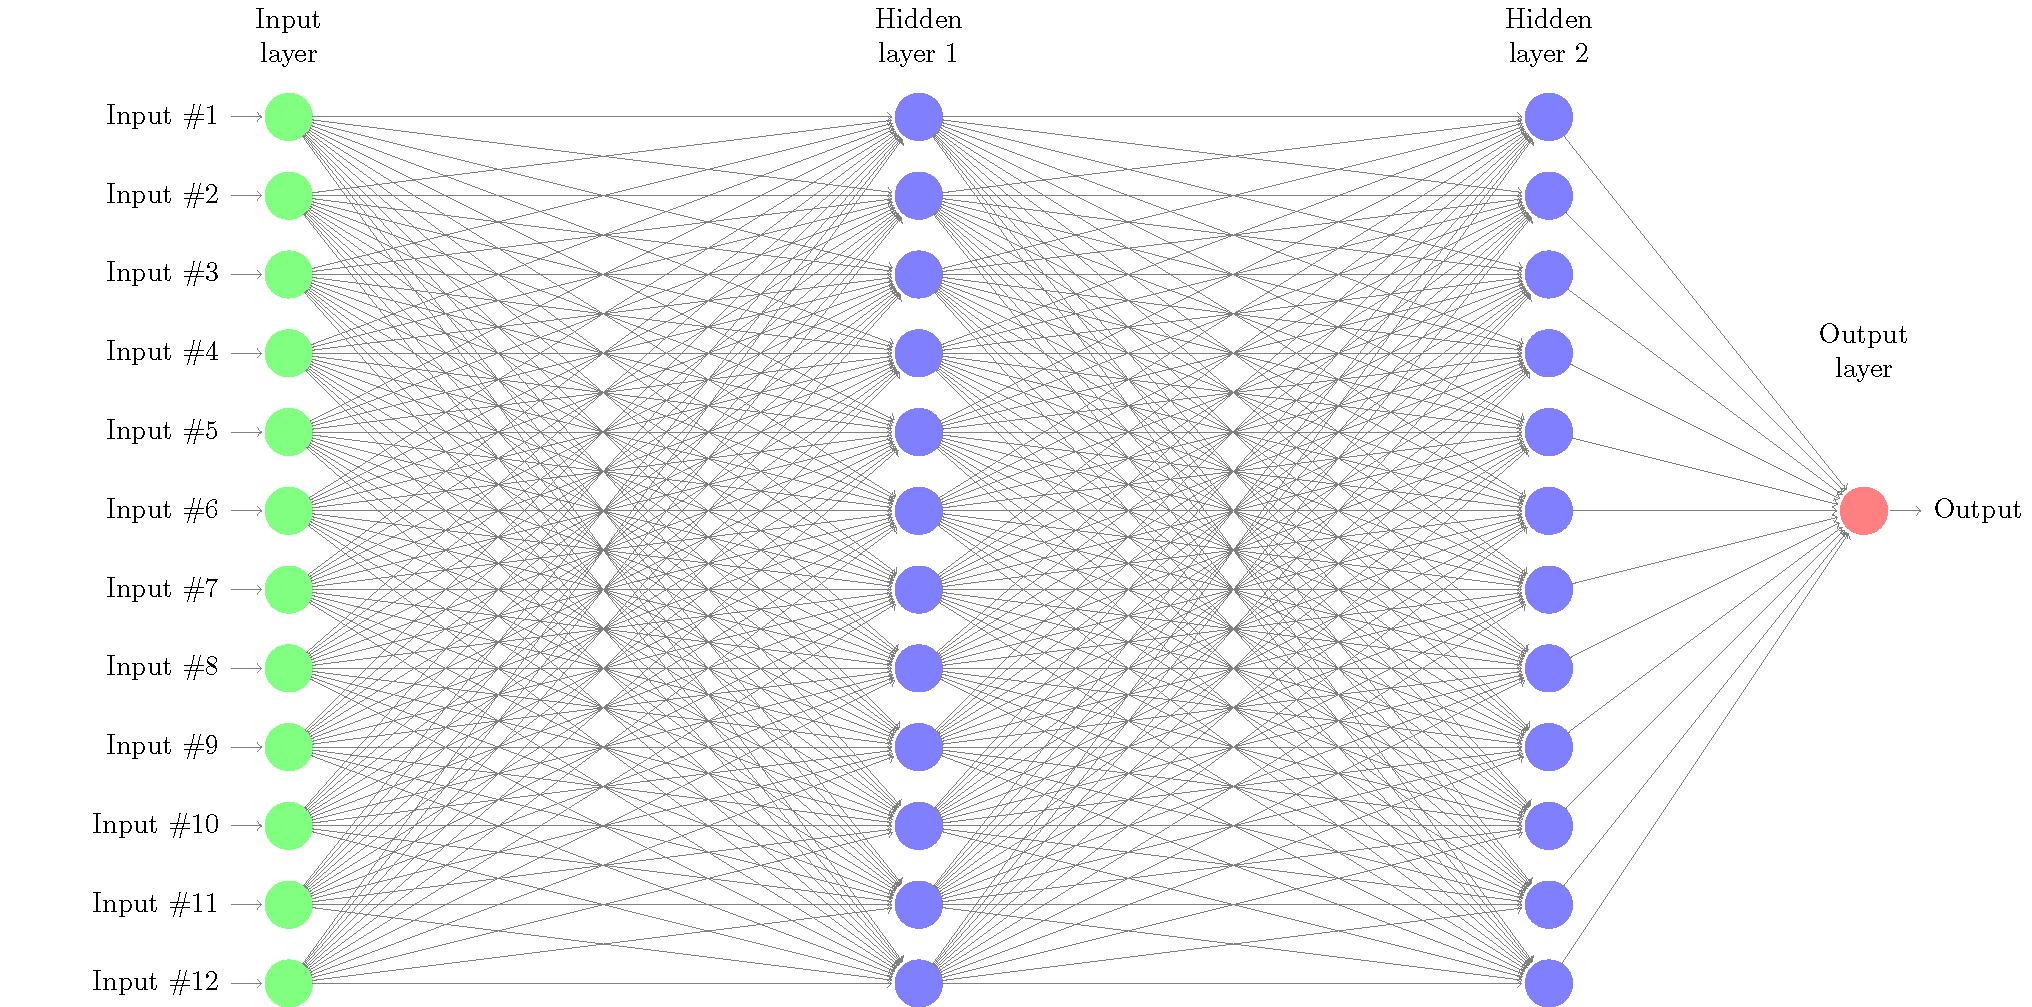

In [7]:
K.clear_session()
n_epochs = 50000
patience = 5000
model = create_model([12, 12], 2)
early_stop_crit = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                patience=patience, verbose=0, mode='auto')

log_dir='./Graph_1_m'
tbCallBack1 = TensorBoard(log_dir=log_dir, histogram_freq=10, write_graph=True, write_grads=True,
                         write_images = True, embeddings_freq = 10, embeddings_layer_names = embedding_layer_names)
start_time = time.time()
history=model.fit(X_train_scalled, Y_train, verbose=0, epochs=n_epochs, validation_data=(X_test_scalled, Y_test),callbacks=[early_stop_crit, tbCallBack1])
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60) )
Image(filename='./plot_modele/A3.png', width=600)

#### Salvare model

In [8]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
model.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del model

In [33]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
model = load_model(nn_filename,custom_objects={'coeff_determination': coeff_determination})
with open(hist_filename, 'rb') as handle:
    history = pickle.load(handle)

Precizia ce mai buna se obtine pentru n_epochs= 1901


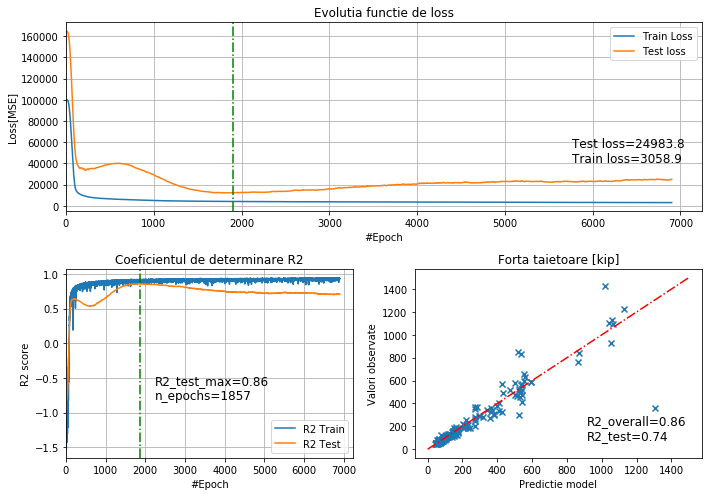

In [35]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'],label='Test loss')
index_min = np.argmin(history['val_loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)
plt.axvline(index_min,c='g',ls='-.')
plt.gcf().text(.80,.67, 'Train loss=%0.1f'%model.evaluate(X_train_scalled, Y_train, verbose=0)[0],fontsize=12)
plt.gcf().text(.80,.70, 'Test loss=%0.1f'%model.evaluate(X_test_scalled, Y_test, verbose=0)[0],fontsize=12)
plt.xlabel('#Epoch')
plt.ylabel('Loss[MSE]')
plt.legend()
plt.grid()
plt.xlim(0)
plt.title('Evolutia functie de loss')

plt.subplot(2, 2, 3)
plt.plot(history['coeff_determination'], label='R2 Train')
plt.plot(history['val_coeff_determination'], label='R2 Test')
plt.grid()
plt.xlabel('#Epoch')
plt.ylabel('R2 score')
plt.title('Coeficientul de determinare R2')
plt.legend()
plt.xlim(0)
r2_max = np.argmax(history['val_coeff_determination'])+1
plt.axvline(r2_max,c='g',ls='-.')
plt.gcf().text(.22,.2, 'R2_test_max=%0.2f\nn_epochs=%i'%(history['val_coeff_determination'][r2_max],r2_max),fontsize=12)

plt.subplot(2, 2, 4)
Y_predicted = model.predict(Xd_scalled)
Y_test_predicted = model.predict(X_test_scalled)
plt.plot([0,1500],[0,1500], c='r', ls='-.')
plt.scatter(Y_predicted, Yd, marker='x')
plt.title('Forta taietoare [kip]')
plt.xlabel('Predictie model')
plt.ylabel('Valori observate')
plt.gcf().text(.82,.15, 'R2_overall=%0.2f'%r2_score(Yd,Y_predicted),fontsize=12)
plt.gcf().text(.82,.12, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted),fontsize=12)
plt.tight_layout()

### Metoda de optimizare prin cautare stochastica

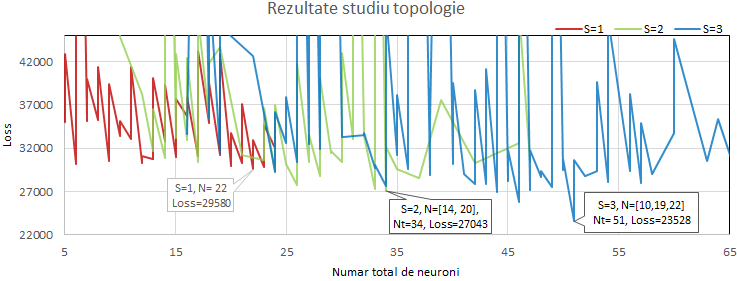

In [12]:
# def R2(y_true,y_pred):    
#     score = r2_score(y_true, y_pred)
#     return score
# def R2_scorer():
#     return make_scorer(R2, greater_is_better=True)

# max_cases = 30000
# max_neurons = 24
# min_neurons = 3
# max_hidden_layers =3
# min_hidden_layers =1
# hidden_layers = [*range(min_hidden_layers,max_hidden_layers+1)]
# neurons = []

# for i in range(max_cases):
#     neurons.append(np.random.randint(min_neurons,max_neurons+1,hidden_layers[-1]+1))

# param_grid = dict(neurons=neurons, hidden_layers=hidden_layers)
# model = KerasRegressor(build_fn=create_model, epochs=1500, batch_size=10,verbose=1)
# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                           cv=2, n_iter=250, verbose=1)
# grid_result = grid.fit(Xd_scalled, Yd, verbose=0, callbacks=[early_stop_crit])
# print("Optim: R2= %0.4f Topologie: %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means[0:10], stds[0:10], params[0:10]):
#     print("R2=%0.4f (stdev=%0.2f) Topologie: %r" % (mean, stdev, param))
# print('...., numar total de topologii testate %i'%len(means))
Image(filename='rezultate_topologii.png')

### Modelul 1 - un singur strat ascuns
#### Antrenare

Timp de antrenare 569.6 secunde / 9.5 minute / 0.2 ore


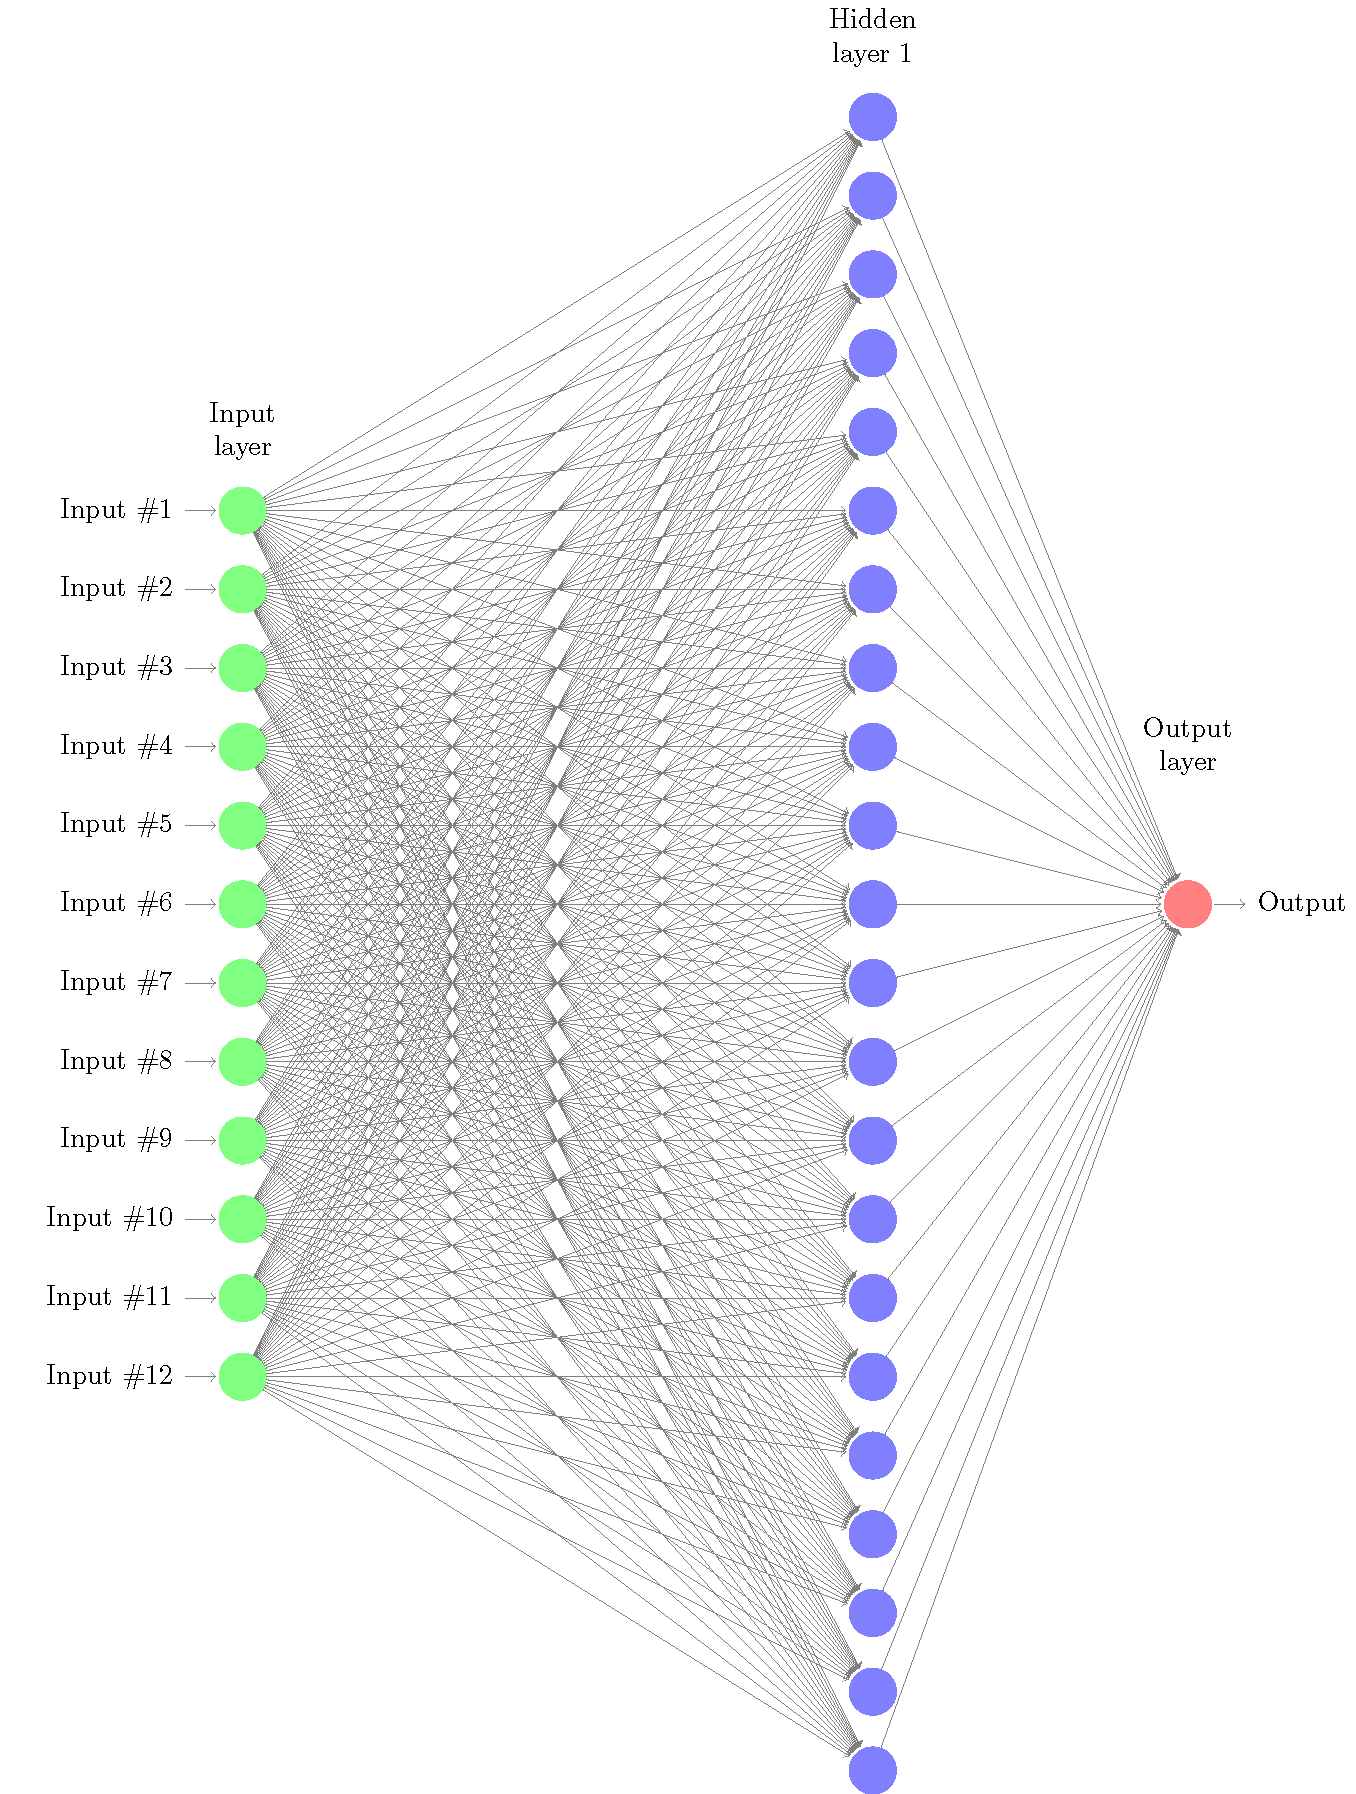

In [13]:
K.clear_session()
neurons=[22,]
layers=1
model_m1 = create_model(neurons, layers)
tbCallBack1_m1 = TensorBoard(log_dir='./Graph_1_m1', histogram_freq=10, write_graph=True, write_grads=True,
                          write_images = True, embeddings_freq = 10, embeddings_layer_names = embedding_layer_names)
start_time = time.time()
history_m1 = model_m1.fit(X_train_scalled, Y_train, verbose=0, epochs=n_epochs, 
                       validation_data=(X_test_scalled, Y_test), callbacks=[tbCallBack1_m1,early_stop_crit])
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))
Image(filename='./plot_modele/A3_m1.png', width=400)

#### Salvare model

In [14]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m1.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m1.pickle')))
model_m1.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history_m1.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del model_m1

In [30]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m1.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m1.pickle')))
model_m1 = load_model(nn_filename,custom_objects={'coeff_determination': coeff_determination})
with open(hist_filename, 'rb') as handle:
    history_m1 = pickle.load(handle)

Precizia ce mai buna se obtine pentru n_epochs= 7455


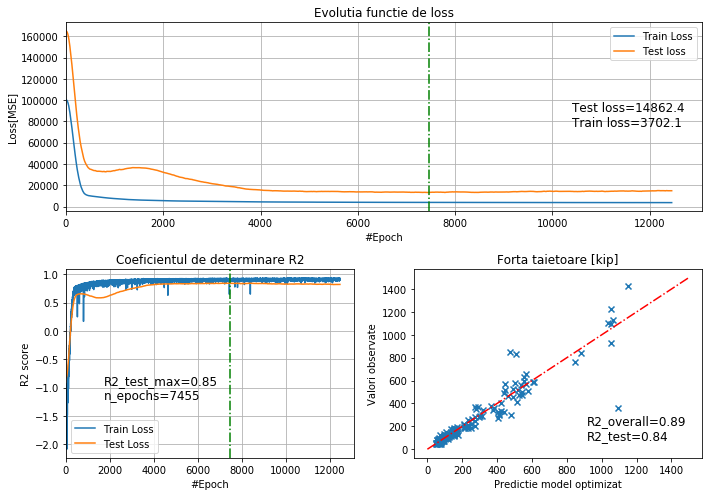

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(history_m1['loss'], label='Train Loss')
plt.plot(history_m1['val_loss'],label='Test loss')
index_min = np.argmin(history_m1['val_loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)
plt.axvline(index_min,c='g',ls='-.')
plt.gcf().text(.80,.74, 'Train loss=%0.1f'%model_m1.evaluate(X_train_scalled, Y_train, verbose=0)[0],fontsize=12)
plt.gcf().text(.80,.77, 'Test loss=%0.1f'%model_m1.evaluate(X_test_scalled, Y_test, verbose=0)[0],fontsize=12)
plt.xlabel('#Epoch')
plt.ylabel('Loss[MSE]')
plt.legend()
plt.grid()
plt.xlim(0)
plt.title('Evolutia functie de loss')

plt.subplot(2, 2, 3)
plt.plot(history_m1['coeff_determination'], label='Train Loss')
plt.plot(history_m1['val_coeff_determination'], label='Test Loss')
plt.grid()
plt.xlabel('#Epoch')
plt.ylabel('R2 score')
plt.title('Coeficientul de determinare R2')
plt.legend()
plt.xlim(0)
r2_max = np.argmax(history_m1['val_coeff_determination'])+1
plt.axvline(r2_max,c='g',ls='-.')
plt.gcf().text(.15,.2, 'R2_test_max=%0.2f\nn_epochs=%i'%(history_m1['val_coeff_determination'][r2_max],r2_max),fontsize=12)

plt.subplot(2, 2, 4)
Y_predicted = model_m1.predict(Xd_scalled)
Y_test_predicted = model_m1.predict(X_test_scalled)
plt.plot([0,1500],[0,1500], c='r', ls='-.')
plt.scatter(Y_predicted, Yd, marker='x')
plt.title('Forta taietoare [kip]')
plt.xlabel('Predictie model optimizat')
plt.ylabel('Valori observate')
plt.gcf().text(.82,.15, 'R2_overall=%0.2f'%r2_score(Yd,Y_predicted),fontsize=12)
plt.gcf().text(.82,.12, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted),fontsize=12)
plt.tight_layout()

### Modelul 2 - doua straturi ascunse
#### Antrenare

Timp de antrenare 1794.0 secunde / 29.9 minute / 0.5 ore


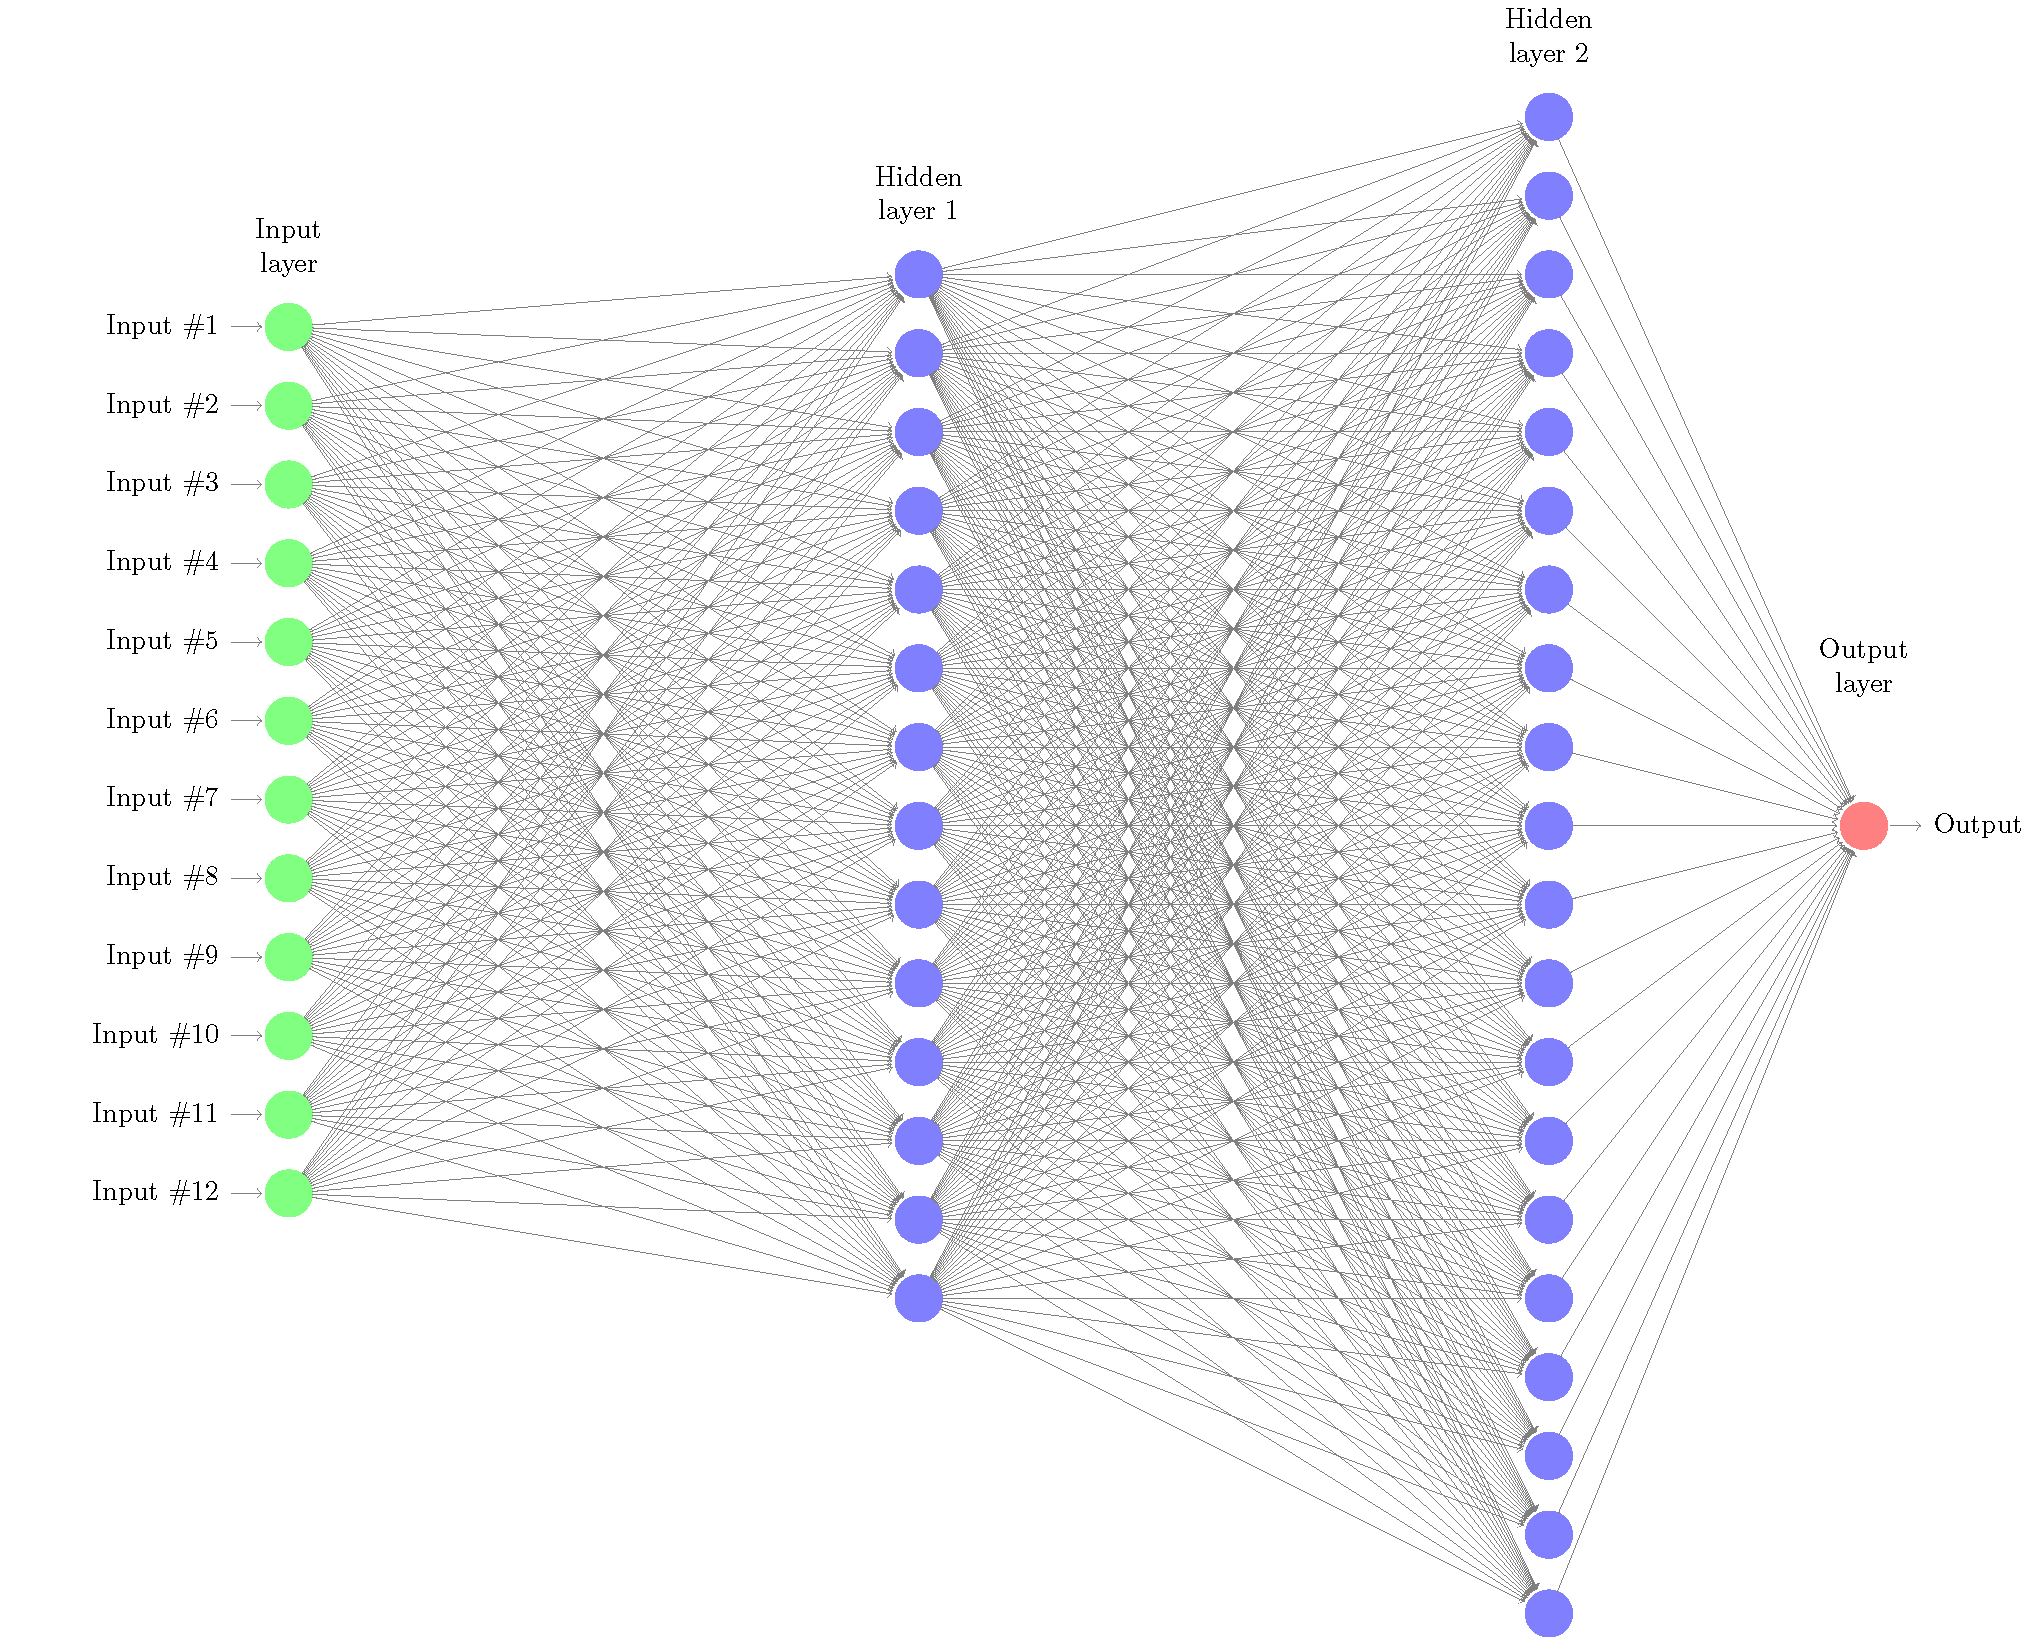

In [18]:
K.clear_session()
neurons=[14,20]
layers=2
model_m2 = create_model(neurons, layers)
tbCallBack1_m2 = TensorBoard(log_dir='./Graph_1_m2', histogram_freq=10, write_graph=True, write_grads=True,
                          write_images = True, embeddings_freq = 10, embeddings_layer_names = embedding_layer_names)
start_time = time.time()
history_m2 = model_m2.fit(X_train_scalled, Y_train, verbose=0, epochs=n_epochs, 
                       validation_data=(X_test_scalled, Y_test), callbacks=[tbCallBack1_m2,early_stop_crit])
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))
Image(filename='./plot_modele/A3_m2.png', width=500)

#### Salvare model

In [19]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m2.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m2.pickle')))
model_m2.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history_m2.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del model_m2

In [26]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m2.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m2.pickle')))
model_m2 = load_model(nn_filename,custom_objects={'coeff_determination': coeff_determination})
with open(hist_filename, 'rb') as handle:
    history_m2 = pickle.load(handle)

Precizia ce mai buna se obtine pentru n_epochs= 21165


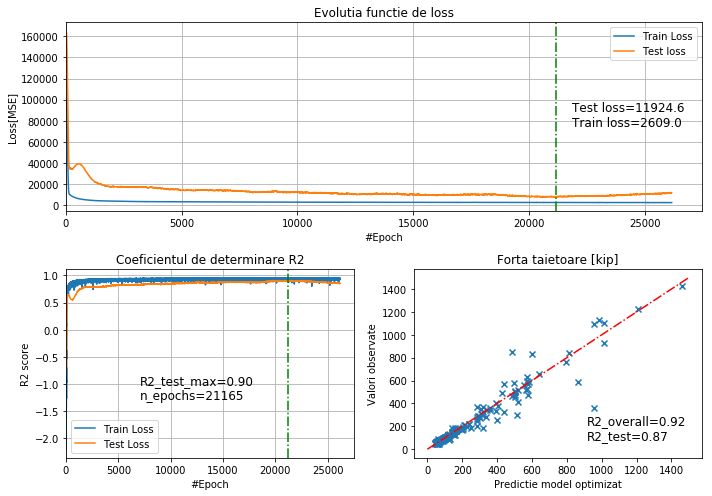

In [29]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(history_m2['loss'], label='Train Loss')
plt.plot(history_m2['val_loss'],label='Test loss')
index_min = np.argmin(history_m2['val_loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)
plt.axvline(index_min,c='g',ls='-.')
plt.gcf().text(.80,.74, 'Train loss=%0.1f'%model_m2.evaluate(X_train_scalled, Y_train, verbose=0)[0],fontsize=12)
plt.gcf().text(.80,.77, 'Test loss=%0.1f'%model_m2.evaluate(X_test_scalled, Y_test, verbose=0)[0],fontsize=12)
plt.xlabel('#Epoch')
plt.ylabel('Loss[MSE]')
plt.legend()
plt.grid()
plt.xlim(0)
plt.title('Evolutia functie de loss')

plt.subplot(2, 2, 3)
plt.plot(history_m2['coeff_determination'], label='Train Loss')
plt.plot(history_m2['val_coeff_determination'], label='Test Loss')
plt.grid()
plt.xlabel('#Epoch')
plt.ylabel('R2 score')
plt.title('Coeficientul de determinare R2')
plt.legend()
plt.xlim(0)
r2_max = np.argmax(history_m2['val_coeff_determination'])+1
plt.axvline(r2_max,c='g',ls='-.')
plt.gcf().text(.2,.2, 'R2_test_max=%0.2f\nn_epochs=%i'%(history_m2['val_coeff_determination'][r2_max],r2_max),fontsize=12)

plt.subplot(2, 2, 4)
Y_predicted = model_m2.predict(Xd_scalled)
Y_test_predicted = model_m2.predict(X_test_scalled)
plt.plot([0,1500],[0,1500], c='r', ls='-.')
plt.scatter(Y_predicted, Yd, marker='x')
plt.title('Forta taietoare [kip]')
plt.xlabel('Predictie model optimizat')
plt.ylabel('Valori observate')
plt.gcf().text(.82,.15, 'R2_overall=%0.2f'%r2_score(Yd,Y_predicted),fontsize=12)
plt.gcf().text(.82,.12, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted),fontsize=12)
plt.tight_layout()

### Modelul 3 - trei straturi ascunse
#### Antrenare

Timp de antrenare 373.7 secunde / 6.2 minute / 0.1 ore


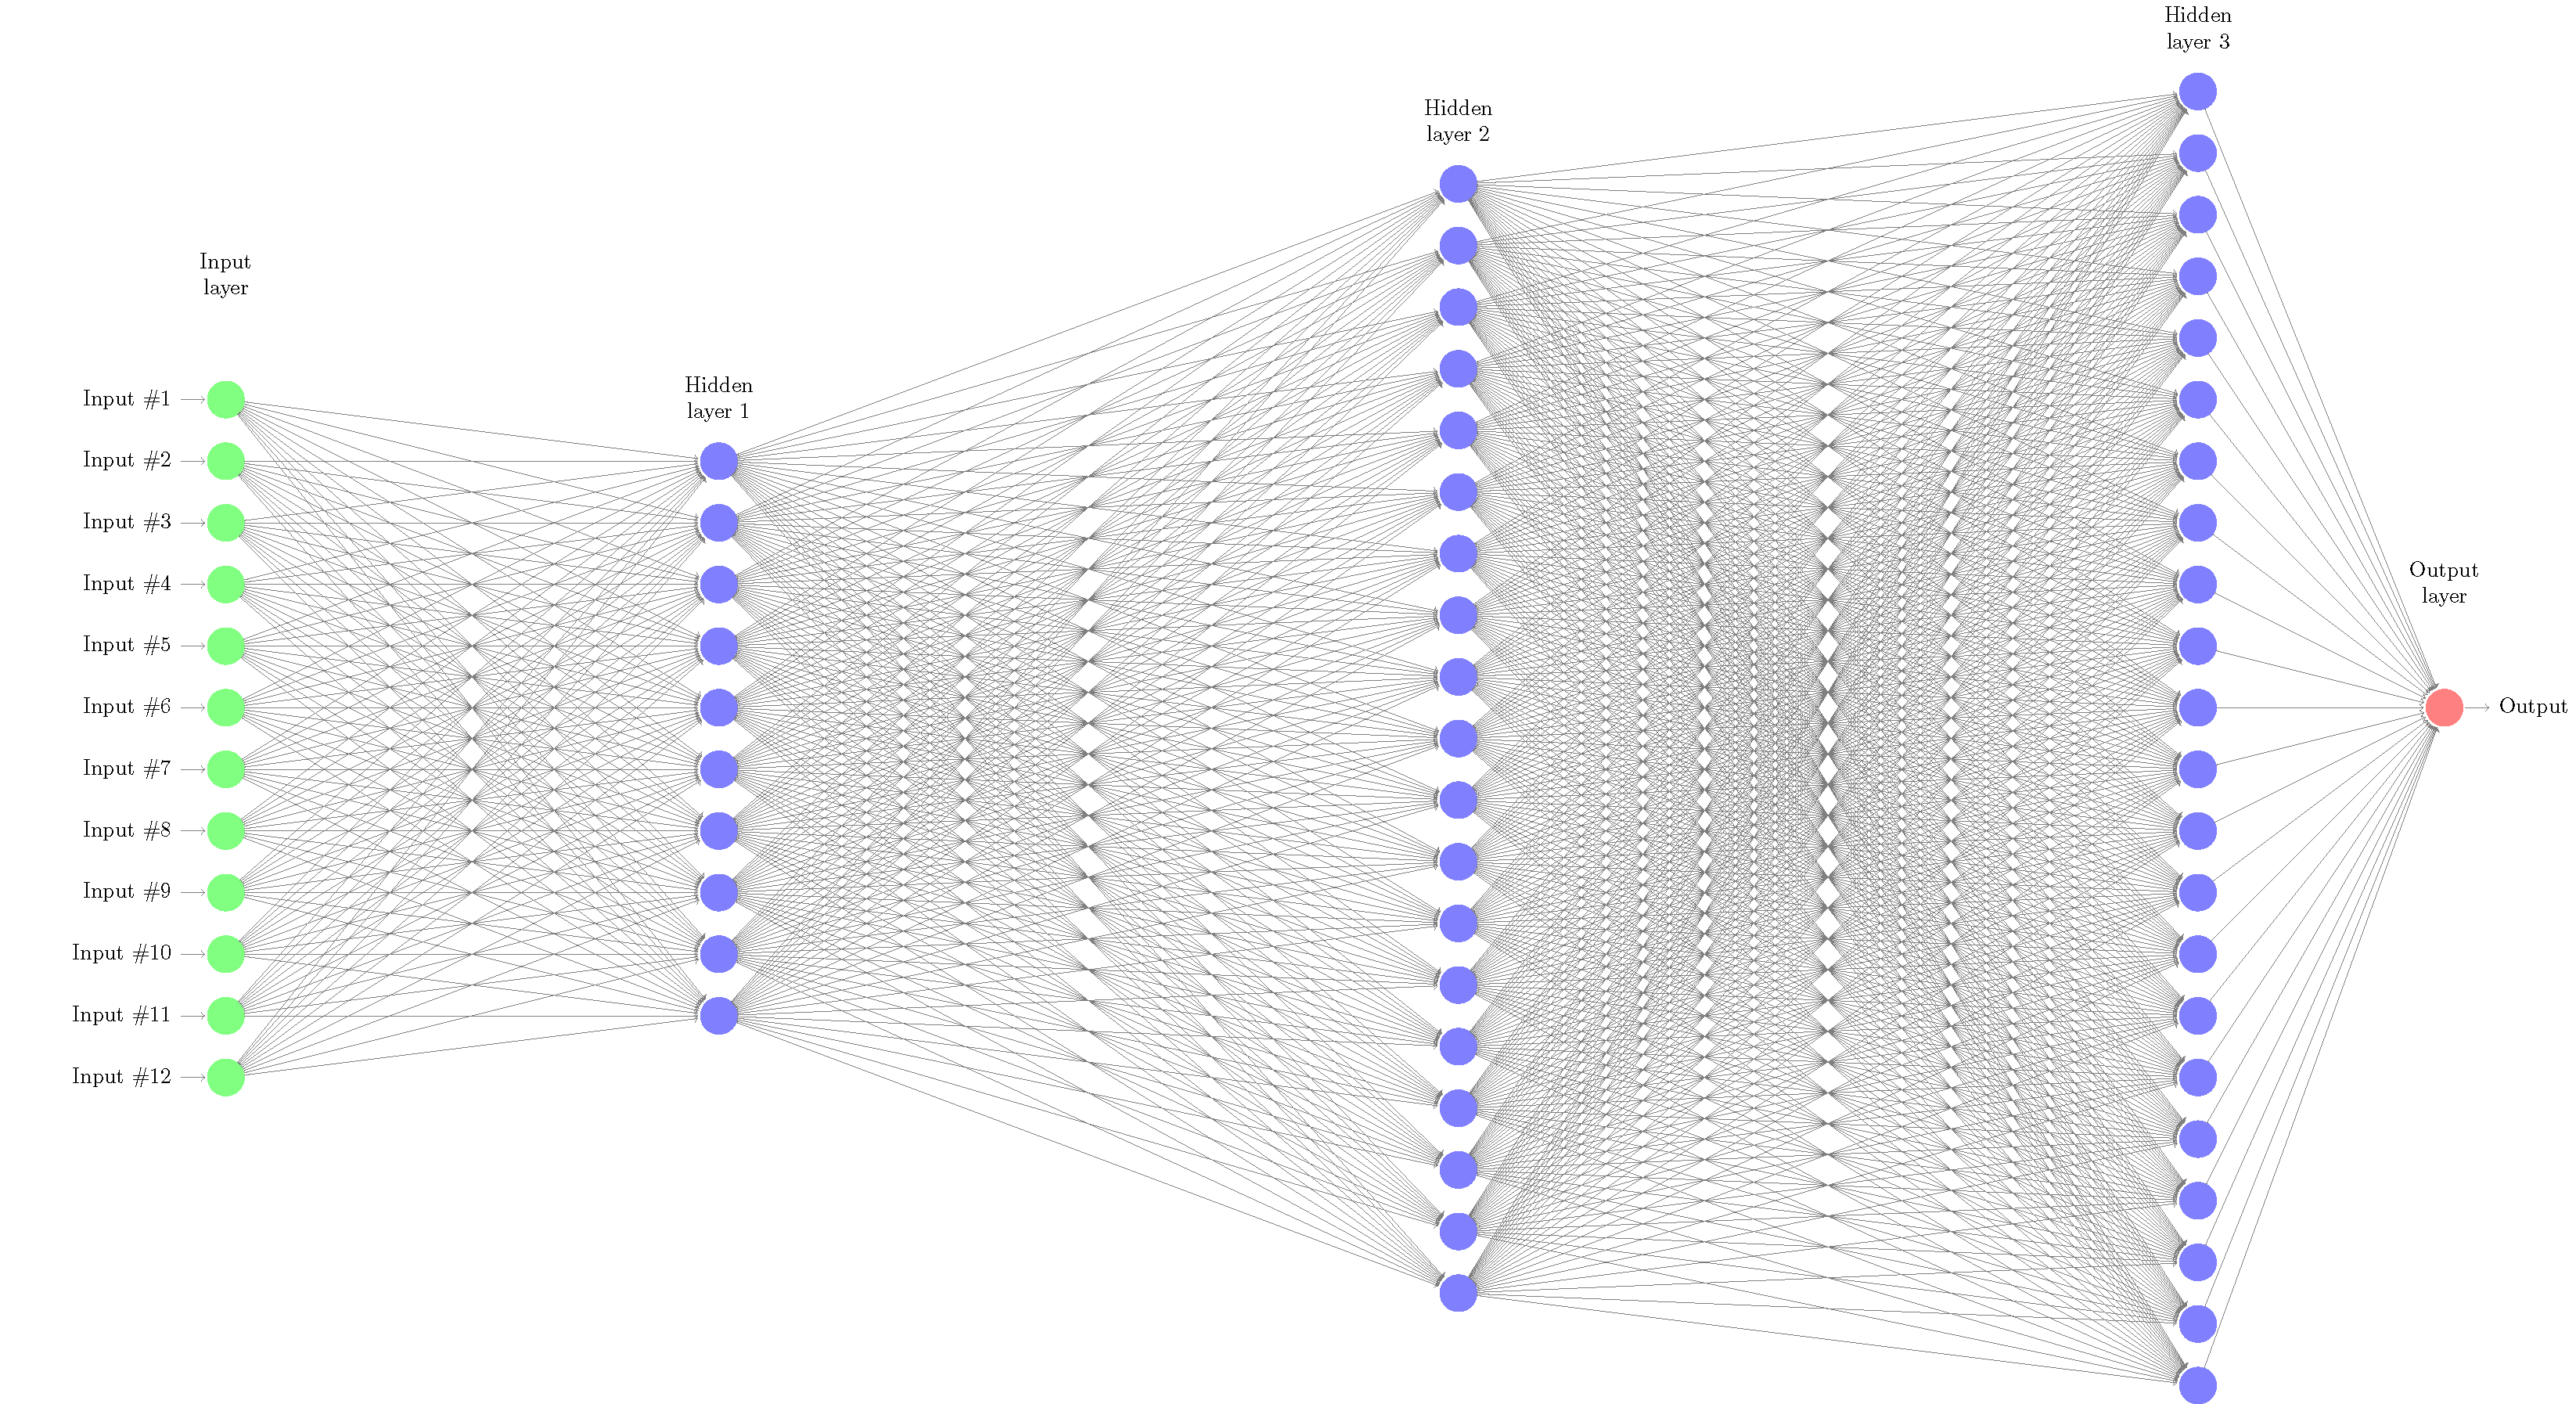

In [9]:
K.clear_session()
neurons=[10,19,22]
layers=3
model_m3 = create_model(neurons, layers)
tbCallBack1_m3 = TensorBoard(log_dir='./Graph_1_m3', histogram_freq=10, write_graph=True, write_grads=True,
                          write_images = True, embeddings_freq = 10, embeddings_layer_names = embedding_layer_names)
start_time = time.time()
history_m3 = model_m3.fit(X_train_scalled, Y_train, verbose=0, epochs=n_epochs, 
                       validation_data=(X_test_scalled, Y_test), callbacks=[tbCallBack1_m3, early_stop_crit])
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))
Image(filename='./plot_modele/A3_m3.png', width=600)

#### Salvare model

In [10]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m3.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m3.pickle')))
model_m3.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history_m3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del model_m3

In [11]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_m3.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_m3.pickle')))
model_m3 = load_model(nn_filename,custom_objects={'coeff_determination': coeff_determination})
with open(hist_filename, 'rb') as handle:
    history_m3 = pickle.load(handle)

Precizia ce mai buna se obtine pentru n_epochs= 1014


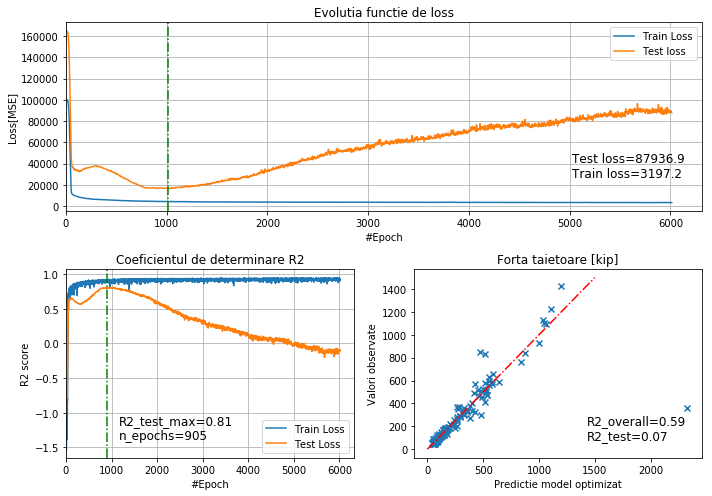

In [24]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(history_m3['loss'], label='Train Loss')
plt.plot(history_m3['val_loss'],label='Test loss')
index_min = np.argmin(history_m3['val_loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)
plt.axvline(index_min,c='g',ls='-.')
plt.gcf().text(.80,.64, 'Train loss=%0.1f'%model_m3.evaluate(X_train_scalled, Y_train, verbose=0)[0],fontsize=12)
plt.gcf().text(.80,.67, 'Test loss=%0.1f'%model_m3.evaluate(X_test_scalled, Y_test, verbose=0)[0],fontsize=12)
plt.xlabel('#Epoch')
plt.ylabel('Loss[MSE]')
plt.legend()
plt.grid()
plt.xlim(0)
plt.title('Evolutia functie de loss')

plt.subplot(2, 2, 3)
plt.plot(history_m3['coeff_determination'], label='Train Loss')
plt.plot(history_m3['val_coeff_determination'], label='Test Loss')
plt.grid()
plt.xlabel('#Epoch')
plt.ylabel('R2 score')
plt.title('Coeficientul de determinare R2')
plt.legend()
plt.xlim(0)
r2_max = np.argmax(history_m3['val_coeff_determination'])+1
plt.axvline(r2_max,c='g',ls='-.')
plt.gcf().text(.17,.12, 'R2_test_max=%0.2f\nn_epochs=%i'%(history_m3['val_coeff_determination'][r2_max],r2_max),fontsize=12)

plt.subplot(2, 2, 4)
Y_predicted = model_m3.predict(Xd_scalled)
Y_test_predicted = model_m3.predict(X_test_scalled)
plt.plot([0,1500],[0,1500], c='r', ls='-.')
plt.scatter(Y_predicted, Yd, marker='x')
plt.title('Forta taietoare [kip]')
plt.xlabel('Predictie model optimizat')
plt.ylabel('Valori observate')
plt.gcf().text(.82,.15, 'R2_overall=%0.2f'%r2_score(Yd,Y_predicted),fontsize=12)
plt.gcf().text(.82,.12, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted),fontsize=12)
plt.tight_layout()